In [27]:
#imports

import numpy as np
import pandas as pd
import pickle 
import gzip
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
#contains synergy values and fold split (numbers 0-4)
labels_file_path = "/home/nidhi/Documents/freelancing/DeepSynergy/data/labels.csv"
labels = pd.read_csv( labels_file_path, index_col=0) 
print(labels.shape)
#labels are duplicated for the two different ways of ordering in the data
#labels = pd.concat([labels, labels]) 

#labels are duplicated for the two different ways of ordering in the data
labels = pd.concat([labels, labels]) 
print(labels.shape)

(23052, 5)
(46104, 5)


In [29]:
labels.head()

,drug_a_name,drug_b_name,cell_line,synergy,fold
5-FU_ABT-888_A2058,5-FU,ABT-888,A2058,7.693530,2
5-FU_ABT-888_A2780,5-FU,ABT-888,A2780,7.778053,2
5-FU_ABT-888_A375,5-FU,ABT-888,A375,-1.198505,2
5-FU_ABT-888_A427,5-FU,ABT-888,A427,2.595684,2
5-FU_ABT-888_CAOV3,5-FU,ABT-888,CAOV3,-5.139971,2


In [30]:
test_fold = 0
val_fold = 1

Data indices for splitting

In [31]:
#indices of training data for hyperparameter selection: fold 2, 3, 4
idx_tr = np.where(np.logical_and(labels['fold']!=test_fold, labels['fold']!=val_fold))
#indices of validation data for hyperparameter selection: fold 1
idx_val = np.where(labels['fold']==val_fold)

In [32]:
#indices of training data for model testing: fold 1, 2, 3, 4
idx_train = np.where(labels['fold']!=test_fold)
#indices of test data for model testing: fold 0
idx_test = np.where(labels['fold']==test_fold)

In [33]:
np.array(idx_test).shape

(1, 9108)

In [34]:
idx_test

(array([  195,   196,   197, ..., 45984, 45985, 45986]),)

In [35]:
plot_y_tr = labels.iloc[idx_tr]
plot_y_val = labels.iloc[idx_val]
plot_y_train = labels.iloc[idx_train]
plot_y_test = labels.iloc[idx_test]

plot_y_tr.reset_index(drop=True, inplace=True)
plot_y_val.reset_index(drop=True, inplace=True)
plot_y_train.reset_index(drop=True, inplace=True)
plot_y_test.reset_index(drop=True, inplace=True)


In [36]:
print(plot_y_test.shape)
plot_y_test.head()

(9108, 5)


,drug_a_name,drug_b_name,cell_line,synergy,fold
0,5-FU,DINACICLIB,A2058,4.331695,0
1,5-FU,DINACICLIB,A2780,-8.161129,0
2,5-FU,DINACICLIB,A375,-5.415934,0
3,5-FU,DINACICLIB,A427,-7.747474,0
4,5-FU,DINACICLIB,CAOV3,-14.347426,0


Note: X_tr and y_tr are used for model training here as per original Github code. 
So, using those for plots. 

Can easily be replaced with X_train and y_train.

X_tr, y_tr (fold = 2,3,4)
X_train, y_train (fold = 1,2,3,4)

Test data:
X_test, y_test (fold = 0)

In [37]:
predictions = pd.read_csv("/home/nidhi/Documents/freelancing/DeepSynergy/data/Results/predictions.csv")
predictions.drop(columns=["Unnamed: 0"], inplace= True)
predictions.columns = ["predictions"]
predictions

,predictions
0,4.529222
1,5.321245
2,5.103267
3,1.266781
4,1.752109
...,...
9103,2.960242
9104,4.097431
9105,4.097431
9106,5.746753


In [38]:
plot_y_test = plot_y_test.join(predictions , how = "left")
plot_y_test = plot_y_test.drop(columns=["fold"])
plot_y_test.head()

,drug_a_name,drug_b_name,cell_line,synergy,predictions
0,5-FU,DINACICLIB,A2058,4.331695,4.529222
1,5-FU,DINACICLIB,A2780,-8.161129,5.321245
2,5-FU,DINACICLIB,A375,-5.415934,5.103267
3,5-FU,DINACICLIB,A427,-7.747474,1.266781
4,5-FU,DINACICLIB,CAOV3,-14.347426,1.752109


KDE plot:
It plots the train data distribution. So, use plot_y_tr for this.

Choose values for Drug A, Drug B, cell line.

In [39]:
drug_a = "5-FU"
drug_b = "DINACICLIB"
cell_line = "OCUBM"

In [40]:
#grouped by cell_line. This will be used for density plots.
grouped = plot_y_tr.groupby('cell_line')

cell_line_group = grouped.get_group(cell_line)
cell_line_group.head()

,drug_a_name,drug_b_name,cell_line,synergy,fold
22,5-FU,ABT-888,OCUBM,3.932148,2
61,5-FU,BORTEZOMIB,OCUBM,-7.508625,2
100,5-FU,ERLOTINIB,OCUBM,28.144439,3
139,5-FU,GELDANAMYCIN,OCUBM,-0.938925,4
178,5-FU,MK-2206,OCUBM,0.751552,2


Plot with bandwidth = 3.589

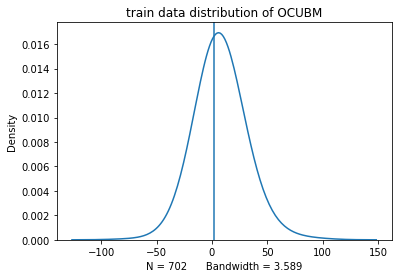

In [41]:
# plot prediction and density plot together
prediction = plot_y_test.loc[(plot_y_test.drug_a_name == drug_a) & (plot_y_test.drug_b_name == drug_b) & (plot_y_test.cell_line == cell_line)].predictions.mean()
bandwidth = 3.589

graph = sns.kdeplot(cell_line_group["synergy"], bw_adjust= 3.589)
graph.axvline(prediction)
plt.xlabel("N = {0}      Bandwidth = {1}".format(cell_line_group.shape[0], bandwidth))
plt.title("train data distribution of {0}".format(cell_line))
#plt.savefig("KDE_plot_fixed_bandwidth.png")
plt.show()

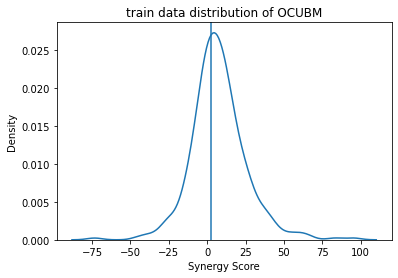

In [42]:
# plot prediction and density plot together
prediction = plot_y_test.loc[(plot_y_test.drug_a_name == drug_a) & (plot_y_test.drug_b_name == drug_b) & (plot_y_test.cell_line == cell_line)].predictions.mean()

graph = sns.kdeplot(cell_line_group["synergy"])
graph.axvline(prediction)
plt.xlabel("Synergy Score")
plt.title("train data distribution of {0}".format(cell_line))
#plt.savefig("KDE_plot_fixed_bandwidth.png")
plt.show()

Heatmap

In [43]:
#group predictions
group_y_test = plot_y_test.groupby(["drug_a_name", "drug_b_name", "cell_line"])


In [44]:
#heatmap can't be created with duplicate entries. Deduplicate,

deduplicated_labels = group_y_test["predictions"].mean().reset_index(name = "pred")
#print(deduplicated_labels.nunique)
print(deduplicated_labels.head())

  drug_a_name drug_b_name cell_line      pred
0        5-FU  DINACICLIB     A2058  4.484058
1        5-FU  DINACICLIB     A2780  5.594605
2        5-FU  DINACICLIB      A375  5.497759
3        5-FU  DINACICLIB      A427  1.147001
4        5-FU  DINACICLIB     CAOV3  1.894421


In [45]:
#group deduplicated_labels by cell_line to generate heatmaps for cell_line individually.
#deduplicated_labels = ddl

ddl_grouped = deduplicated_labels.groupby("cell_line")
ddl_grouped_keys = [key for key, _ in ddl_grouped]

print(len(ddl_grouped_keys))


39


In [46]:
#ready data

ddl_cell_line = ddl_grouped.get_group(cell_line)
#print(ddl_A2058.head())
print(ddl_cell_line.shape)

#print(ddl_A2058.iloc[:,[0,1]].nunique())
#double check drug pairs are unique.
unique_drugpairs_in_ddl_cell_line = [key for key, _ in ddl_cell_line.groupby(["drug_a_name","drug_b_name"])]
print(len(unique_drugpairs_in_ddl_cell_line))

#remove cell_line column. 
cell_line_heatmap = ddl_cell_line.iloc[:,[0,1,3]].copy()
cell_line_heatmap = ddl_cell_line.pivot("drug_a_name", "drug_b_name", "pred")


(116, 4)
116


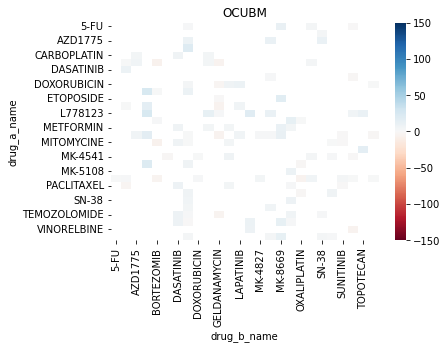

In [47]:

#sns.color_palette("RdBu")
sns.heatmap(cell_line_heatmap, center = 0, vmin = -150, vmax = 150, cmap = "RdBu")
plt.title(cell_line)
#plt.savefig("Heatmap.png")
plt.show()
